In [22]:
# check GPU availability
import tensorflow as tf
print('tf version {}'.format(tf.__version__))
print('Is GPU available {}'.format(tf.test.is_gpu_available()))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

tf version 1.11.0
Is GPU available True
Found GPU at: /device:GPU:0


In [80]:
# run one experiment from scratch
%load_ext autoreload
%autoreload 2
import os
import tensorflow as tf
tf.reset_default_graph()
from model import Model
from cfg import get_cfg
from utils import get_experiment_name
from utils import dotdict

experiments_folder = os.path.join(os.getcwd(), 'results')
experiment_name, experiment_folder = get_experiment_name(experiments_folder)

#cfg_env, cfg_agent = get_cfg(experiment_folder, 'CartPole-v0', 'ppo')
cfg_env, cfg_agent = get_cfg(experiment_folder, 'four_rooms_maze', 'ppo_predictor_fixed_weights')
cfg = cfg_env
cfg.update(cfg_agent)

cfg = dotdict(cfg)
cfg.n_batches = 100
cfg.n_episodes = 100
cfg.log_step = 10
#cfg.observation_encoding = ['normalise']
#cfg.batch_size = 1
#cfg.baseline = 'advantage'
#cfg.agent_d_hidden_layers = [1]
#cfg.baseline_d_hidden_layers = [1]
model = Model(cfg)
model.train_model()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
ep 10 st 200 ppo_predictor_fixed_weights e.ret.tr 0.00 e.ret.ts 0.00 ag.ls -0.80 bs.ls 1.20 i.ret 1.98 pr.ls 4.43 vis 27.00 
ep 20 st 400 ppo_predictor_fixed_weights e.ret.tr 0.00 e.ret.ts 0.00 ag.ls -0.58 bs.ls 0.77 i.ret 1.94 pr.ls 1.92 vis 30.00 
ep 30 st 600 ppo_predictor_fixed_weights e.ret.tr 0.00 e.ret.ts 0.00 ag.ls -0.21 bs.ls 0.33 i.ret 1.86 pr.ls 1.24 vis 32.00 
ep 40 st 800 ppo_predictor_fixed_weights e.ret.tr 0.00 e.ret.ts 0.00 ag.ls 0.02 bs.ls 0.27 i.ret 1.85 pr.ls 0.71 vis 32.00 
ep 50 st 1000 ppo_predictor_fixed_weights e.ret.tr 0.00 e.ret.ts 0.00 ag.ls 0.04 bs.ls 0.25 i.ret 1.85 pr.ls 1.06 vis 32.00 
ep 60 st 1200 ppo_predictor_fixed_weights e.ret.tr 0.00 e.ret.ts 0.00 ag.ls -0.02 bs.ls 0.22 i.ret 1.80 pr.ls 0.68 vis 34.00 
ep 70 st 1400 ppo_predictor_fixed_weights e.ret.tr 0.00 e.ret.ts 0.00 ag.ls -0.05 bs.ls 0.22 i.ret 1.80 pr.ls 0.92 vis 34.00 
ep 80 st 1600 ppo_predictor_fixed_we

0.0 20.0 5


<IPython.core.display.Javascript object>


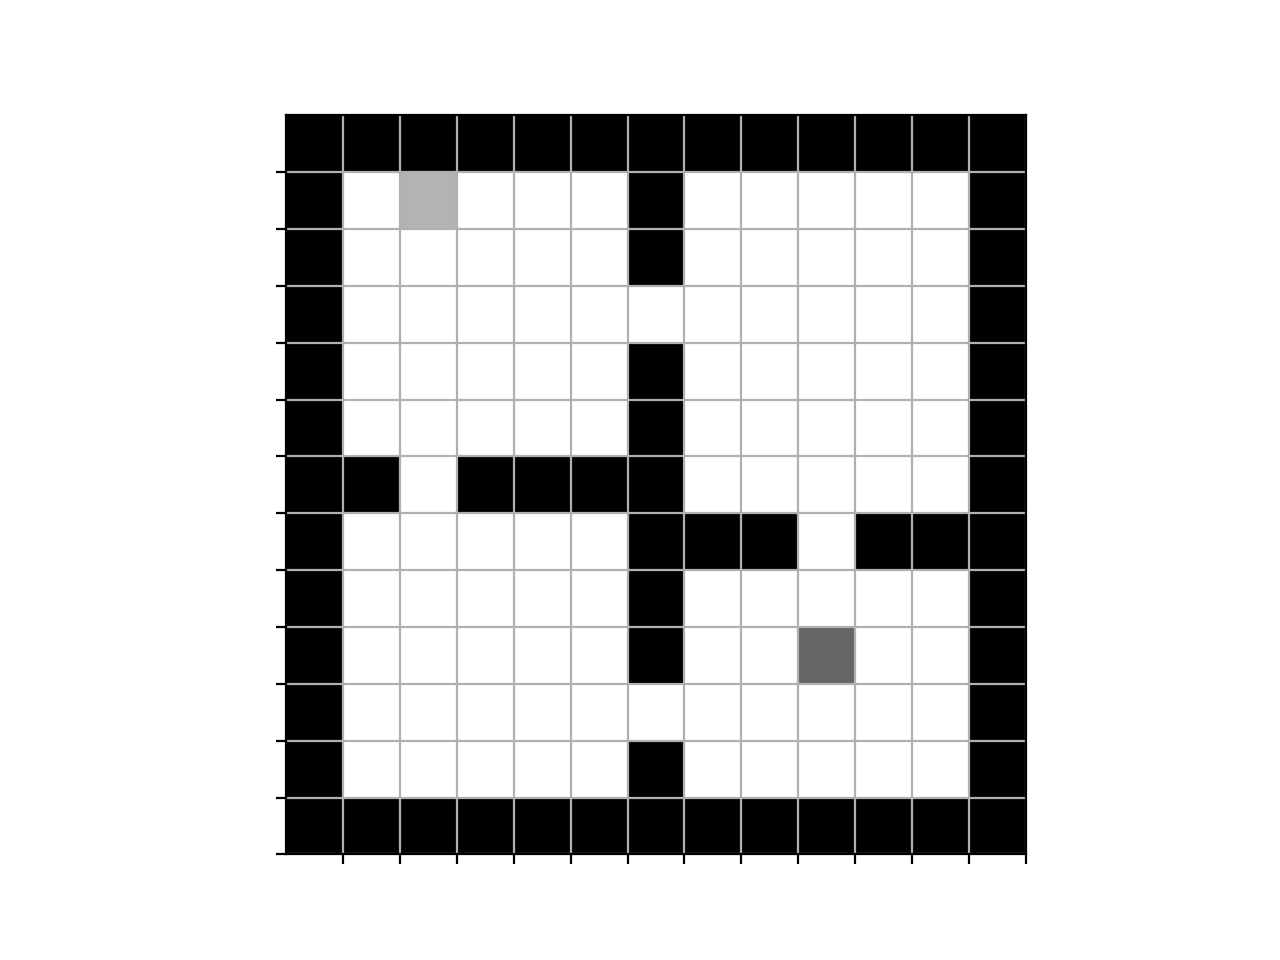

In [9]:
# simulate one maze episode 
import matplotlib 
%matplotlib nbagg
ext_return, n_steps, obs_list = model.simulate()
print(ext_return, n_steps, len(model.env.visited))
model.env.animate(obs_list)

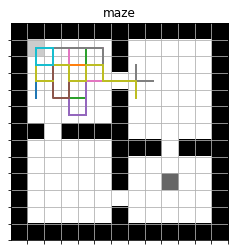

In [72]:
# show different trajectories in maze
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
obs_batch = []
for _ in range(10):
    ext_return, n_steps, obs_buffer = model.simulate() 
    obs_batch.append(obs_buffer)
model.env.render_maze('maze', obs_batch)

In [4]:
# simulate one episode in OpenAI gym
obs, ext_return, done = model.env.reset(), 0., False
n_steps, _return = 0, 0
while not done:
    action = model.action(obs)
    obs, r, done, _ = model.env.step(action)
    _return += r
    n_steps += 1
    model.env.render()
model.env.close()
print(_return, n_steps)

13.0 13


In [8]:
# tf events to csv
from utils import tf_events_to_csv
from utils import subdir_paths
for dpath in subdir_paths(experiment_folder):
    tf_events_to_csv(dpath)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 1080x1080 with 0 Axes>

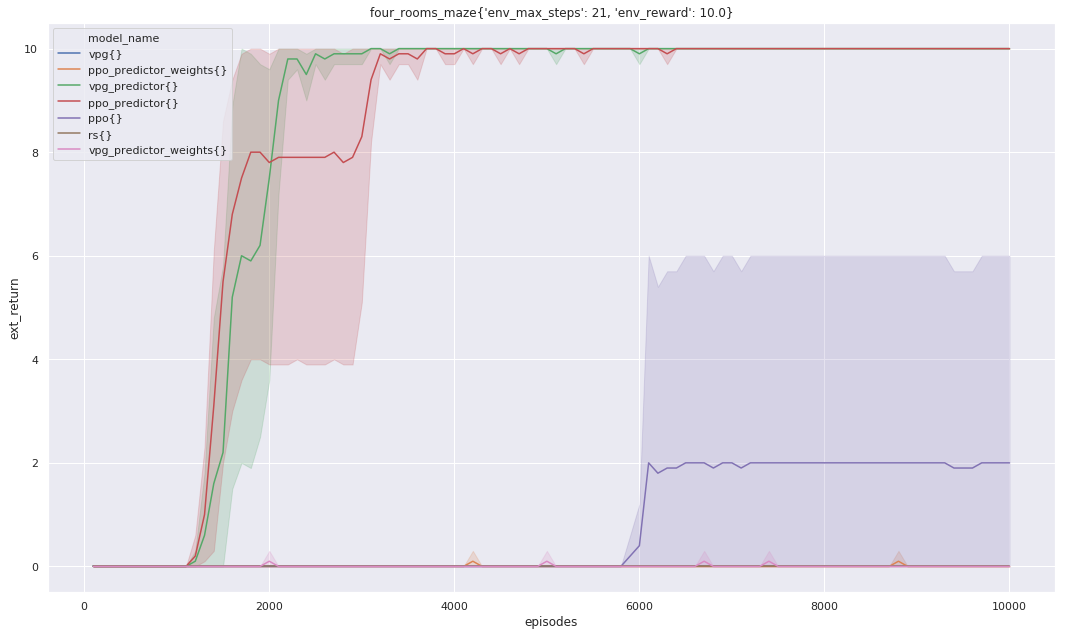

{'activation': 'tanh', 'agent_buffer_batch_size': 64, 'agent_buffer_size': 10000, 'agent_d_hidden_layers': [32], 'agent_learning_rate': 0.001, 'baseline': 'advantage', 'baseline_d_hidden_layers': [32], 'baseline_learning_rate': 0.001, 'batch_size': 1, 'clip_int_reward': 0.1, 'clip_range': 0.2, 'env_max_steps': 21, 'env_name': 'four_rooms_maze', 'env_reward': 10.0, 'experiment_folder': '/home/raoul/code/dev/curiosity/results/2', 'gae_lamda': 0.97, 'global_step': 0, 'log_step': 100, 'model_name': 'ppo_predictor', 'n_batches': 10000, 'n_episodes': 10000, 'observation_encoding': 'one_hot', 'predictor_buffer_batch_size': 64, 'predictor_buffer_size': 10000, 'predictor_d_hidden_layers': [32], 'predictor_learning_rate': 0.001, 'reward_discount_factor': 0.99, 'seed': 0, 'time_reward': 0.0, 'verbose': False}
{'activation': 'tanh', 'agent_buffer_batch_size': 64, 'agent_buffer_size': 10000, 'agent_d_hidden_layers': [32], 'agent_learning_rate': 0.001, 'baseline': 'advantage', 'baseline_d_hidden_lay

In [40]:
# hpsearch plots
%load_ext autoreload
%autoreload 2
import os
from utils import plot_hp_sensitivities
from utils import find_optimal_hp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
experiment_folder = os.path.join(os.getcwd(), 'results_train/four_rooms_maze/pg_one_hot_encoding')
experiment_folder = os.path.join(os.getcwd(), 'results_hpsearch/four_rooms_maze/pg_baseline_predictor_weights')
experiment_folder = os.path.join(os.getcwd(), 'results/x05/results/2')

if True:
    plt.figure(figsize=(15,15))
    plot_hp_sensitivities(experiment_folder, 
                      'ext_return', 
                      'model_name', 
                      {
                       #'model_name': ['ppo'],
                       #'observation_encoding': ['one_hot'],
                       #'policy_d_hidden_layers': [[32,32]],
                       #'predictor_d_hidden_layers': [[16]],
                       #'activation': 'tanh'
                       #'clip_range': [0.1, 0.2]
                      },
                      details=False,
                      box_pts=1,
                      show=True)
if True:
    find_optimal_hp(experiment_folder, 'ext_return', {})
    find_optimal_hp(experiment_folder, 'n_states_visited', {})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/raoul/.virtualenvs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

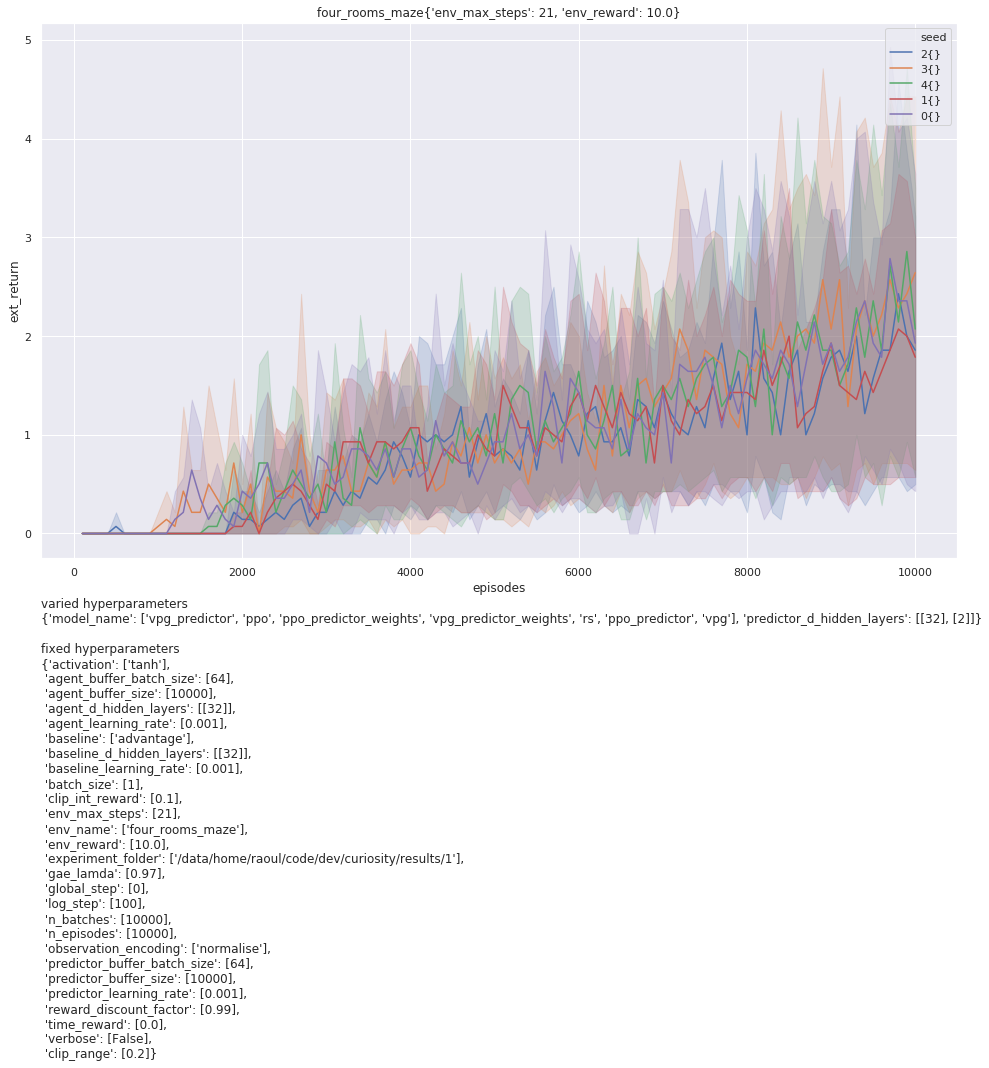

<Figure size 432x288 with 0 Axes>

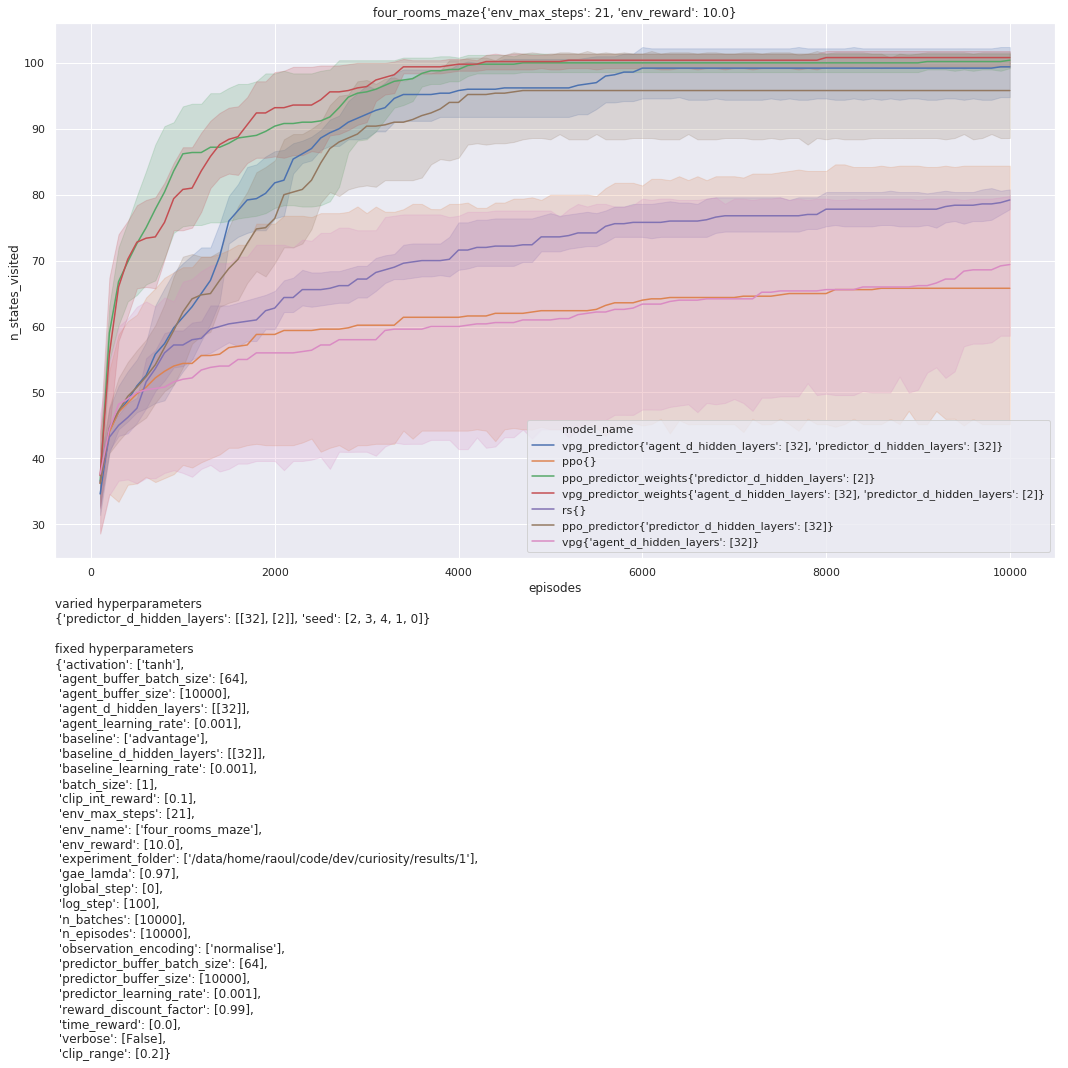

In [2]:
# final results plots
%load_ext autoreload
%autoreload 2
import os
from utils import plot_hp_sensitivities
from utils import find_optimal_hp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
experiment_folder = os.path.join(os.getcwd(), 'results/x03/results/1')
experiment_folder = os.path.join(os.getcwd(), 'results_train/four_rooms_maze/normalise_encoding')
plot_hp_sensitivities(experiment_folder, 'ext_return','seed',{
    #'model_name': ['ppo_predictor_weights']
                                                                   }, details=True, box_pts=1, show=True)
plot_hp_sensitivities(experiment_folder, 'n_states_visited','model_name',{
    #'model_name': ['ppo', 'ppo_predictor', 'ppo_predictor_weights', 'rs']
}, details=True, box_pts=1, show=True)

In [1]:
# load maze experiments and show multiple trajectories
%load_ext autoreload
%autoreload 2
import os
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from model import Model
from utils import subdir_paths
from envs import make_env

experiment_folder = os.path.join(os.getcwd(), 'results/5')
experiment_folder = os.path.join(os.getcwd(), 'results/uranus/results/3')
experiment_folder = os.path.join(os.getcwd(), 'results_train/four_rooms_maze/normalise_encoding')

if False:
    # one model
    model_number = 34
    fnames = os.listdir(experiment_folder)
    dpaths = [os.path.join(experiment_folder, fname) for fname in fnames if ('Model_'+str(model_number)+'_') in fname]
else:
    # all models
    dpaths = subdir_paths(experiment_folder)

for dpath in dpaths:
    tf.reset_default_graph()
    model = Model.load(dpath)
    
    if model.cfg.seed == 4:
        obs_batch = []
        n_episodes = 100
        for _ in range(n_episodes):
            #model.env = make_env(model.env_name, model.env_max_steps, model.env_reward, variation=True)
            ext_return, n_steps, obs_buffer = model.simulate()
            obs_batch.append(obs_buffer)
        fpath = os.path.join(experiment_folder, 'maze_' + model.model_name + '.png') 
        model.env.render_maze(model.model_name, obs_batch, fpath)

INFO:tensorflow:Restoring parameters from /home/raoul/code/dev/curiosity/results_train/four_rooms_maze/normalise_encoding/Model_12_cfg={'experiment_folder': '_data_home_raoul_code_dev_curiosity_results_1', 'verbose': False, 'env_name': 'four_rooms_maze_2019-03-21_17-35-50q3zc_ycs/vpg_ckpt-10000
INFO:tensorflow:Restoring parameters from /home/raoul/code/dev/curiosity/results_train/four_rooms_maze/normalise_encoding/Model_12_cfg={'experiment_folder': '_data_home_raoul_code_dev_curiosity_results_1', 'verbose': False, 'env_name': 'four_rooms_maze_2019-03-21_17-35-50q3zc_ycs/predictor_ckpt-200000
INFO:tensorflow:Restoring parameters from /home/raoul/code/dev/curiosity/results_train/four_rooms_maze/normalise_encoding/Model_12_cfg={'experiment_folder': '_data_home_raoul_code_dev_curiosity_results_1', 'verbose': False, 'env_name': 'four_rooms_maze_2019-03-21_17-35-50q3zc_ycs/baseline_ckpt-10000
INFO:tensorflow:Restoring parameters from /home/raoul/code/dev/curiosity/results_train/four_rooms_ma

/home/raoul/.virtualenvs/py3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using ps, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


INFO:tensorflow:Restoring parameters from /home/raoul/code/dev/curiosity/results_train/four_rooms_maze/normalise_encoding/Model_20_cfg={'experiment_folder': '_data_home_raoul_code_dev_curiosity_results_1', 'verbose': False, 'env_name': 'four_rooms_maze_2019-03-21_17-39-24xca0rp2c/baseline_ckpt-10000
INFO:tensorflow:Restoring parameters from /home/raoul/code/dev/curiosity/results_train/four_rooms_maze/normalise_encoding/Model_29_cfg={'experiment_folder': '_data_home_raoul_code_dev_curiosity_results_1', 'verbose': False, 'env_name': 'four_rooms_maze_2019-03-21_18-15-39hnfwa3wp/ppo_ckpt-10000
INFO:tensorflow:Restoring parameters from /home/raoul/code/dev/curiosity/results_train/four_rooms_maze/normalise_encoding/Model_29_cfg={'experiment_folder': '_data_home_raoul_code_dev_curiosity_results_1', 'verbose': False, 'env_name': 'four_rooms_maze_2019-03-21_18-15-39hnfwa3wp/predictor_ckpt-200000
INFO:tensorflow:Restoring parameters from /home/raoul/code/dev/curiosity/results_train/four_rooms_ma

INFO:tensorflow:Restoring parameters from /home/raoul/code/dev/curiosity/results_train/four_rooms_maze/normalise_encoding/Model_5_cfg={'experiment_folder': '_data_home_raoul_code_dev_curiosity_results_1', 'verbose': False, 'env_name': 'four_rooms_maze'_2019-03-21_17-35-14rwnio_e2/baseline_ckpt-10000
INFO:tensorflow:Restoring parameters from /home/raoul/code/dev/curiosity/results_train/four_rooms_maze/normalise_encoding/Model_34_cfg={'experiment_folder': '_data_home_raoul_code_dev_curiosity_results_1', 'verbose': False, 'env_name': 'four_rooms_maze_2019-03-21_18-55-399fcs2vsm/ppo_ckpt-10000
INFO:tensorflow:Restoring parameters from /home/raoul/code/dev/curiosity/results_train/four_rooms_maze/normalise_encoding/Model_34_cfg={'experiment_folder': '_data_home_raoul_code_dev_curiosity_results_1', 'verbose': False, 'env_name': 'four_rooms_maze_2019-03-21_18-55-399fcs2vsm/predictor_ckpt-200000
INFO:tensorflow:Restoring parameters from /home/raoul/code/dev/curiosity/results_train/four_rooms_ma

INFO:tensorflow:Restoring parameters from /home/raoul/code/dev/curiosity/results_train/four_rooms_maze/normalise_encoding/Model_10_cfg={'experiment_folder': '_data_home_raoul_code_dev_curiosity_results_1', 'verbose': False, 'env_name': 'four_rooms_maze_2019-03-21_17-35-14qqqtgvdx/baseline_ckpt-10000
